In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/train_data.zip

# 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory ../data/images/ with:

noisy labels for all images provided in ../data/noisy_label.csv;
clean labels for the first 10000 images provided in ../data/clean_labels.csv.

In [14]:
# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
# load the labels
clean_labels = np.genfromtxt('clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('noisy_labels.csv', delimiter=',', dtype="int8")

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


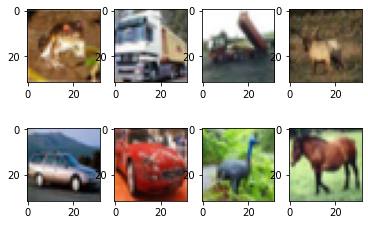

In [5]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


In [6]:
def preprocess(image,label):
  image2 = tf.cast(image,dtype=tf.float64)/225.0
  return image2,label

In [7]:
img_train_noisy,img_vali_noisy,labels_train_noisy, labels_vali_noisy= train_test_split(imgs,noisy_labels,test_size = 0.2,random_state=4)
noisy_train_dataset= tf.data.Dataset.from_tensor_slices((img_train_noisy, labels_train_noisy))
noisy_vali_dataset = tf.data.Dataset.from_tensor_slices((img_vali_noisy, labels_vali_noisy))
noisy_train_set =noisy_train_dataset.map(preprocess)
noisy_vali_set = noisy_vali_dataset.map(preprocess)
noisy_train_ds = noisy_train_set.cache().batch(4).prefetch(buffer_size=10)
noisy_vali_ds = noisy_vali_set.cache().batch(4).prefetch(buffer_size=10)

# 2. The predictive model
We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.



### 2.1. Baseline Model

In [8]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [9]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [10]:
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

In [11]:
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

# Model I
For model I, we treat noisy label as clean labels and ultilize the tranfer learning with a VGG16 model as pretrained model.The accuracy of prediction on clean labels only dataset is around 54%. 

In [12]:
pre_model = tf.keras.Sequential()

pre_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',
                   weights='imagenet')
pre_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
#pre_model.summary()

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_model.layers:
        layer.trainable=False
VGG16_model = tf.keras.Sequential()
VGG16_model.add(pre_model)
VGG16_model.add(tf.keras.layers.Flatten())
VGG16_model.add(tf.keras.layers.Dense(10, activation='softmax'))
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
model1_history = VGG16_model.fit(noisy_train_ds,epochs = 20,
          verbose=1, 
          validation_data = noisy_vali_ds)


Epoch 1/20
10000/10000 [==============================] - 90s 8ms/step - loss: 2.2819 - accuracy: 0.1579 - val_loss: 2.2431 - val_accuracy: 0.2016
Epoch 2/20
10000/10000 [==============================] - 80s 8ms/step - loss: 2.2313 - accuracy: 0.2107 - val_loss: 2.2268 - val_accuracy: 0.2203
Epoch 3/20
10000/10000 [==============================] - 79s 8ms/step - loss: 2.2158 - accuracy: 0.2259 - val_loss: 2.2191 - val_accuracy: 0.2276
Epoch 4/20
10000/10000 [==============================] - 80s 8ms/step - loss: 2.2060 - accuracy: 0.2340 - val_loss: 2.2145 - val_accuracy: 0.2338
Epoch 5/20
10000/10000 [==============================] - 79s 8ms/step - loss: 2.1988 - accuracy: 0.2396 - val_loss: 2.2115 - val_accuracy: 0.2380
Epoch 6/20
10000/10000 [==============================] - 79s 8ms/step - loss: 2.1930 - accuracy: 0.2430 - val_loss: 2.2095 - val_accuracy: 0.2406
Epoch 7/20
10000/10000 [==============================] - 79s 8ms/step - loss: 2.1883 - accuracy: 0.2452 - val_loss: 2

In [ ]:
#VGG16_model.save("VGG16_model",save_format='h5')

<function matplotlib.pyplot.show(*args, **kw)>

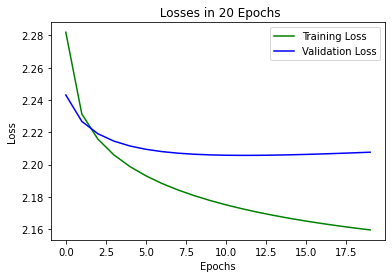

In [14]:
training_losses = model1_history.history["loss"]
vali_losses = model1_history.history["val_loss"]
epochs = range(0,20)
plt.plot(epochs,training_losses,"g",label = "Training Loss")
plt.plot(epochs,vali_losses,"b",label = "Validation Loss")
plt.title(" Losses in 20 Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

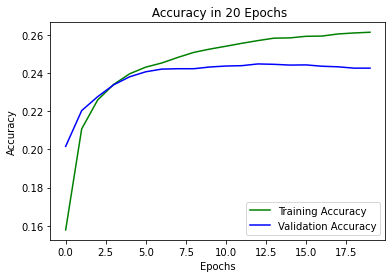

In [15]:
training_accuracy = model1_history.history["accuracy"]
vali_accuracy = model1_history.history["val_accuracy"]
epochs = range(0,20)
plt.plot(epochs,training_accuracy,"g",label = "Training Accuracy")
plt.plot(epochs,vali_accuracy,"b",label = "Validation Accuracy")
plt.title(" Accuracy in 20 Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

In [16]:
clean_dataset = tf.data.Dataset.from_tensor_slices((imgs[:10000], clean_labels))
clean_set =clean_dataset.map(preprocess)
clean_ds = clean_set.cache().batch(4).prefetch(buffer_size=10)
VGG16_model.evaluate(clean_ds)

2500/2500 [==============================] - 17s 7ms/step - loss: 1.7499 - accuracy: 0.5482


[1.7499467134475708, 0.5482000112533569]

2500/2500 [==============================] - 17s 7ms/step - loss: 1.7499 - accuracy: 0.5482
[1.7499467134475708, 0.5482000112533569]

In [17]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    classes_hat = VGG16_model.predict(np.array([image/225,]))
    y_pred=np.argmax(classes_hat,axis=1)
    return(y_pred)

In [ ]:
evaluation(model_I, clean_labels, imgs[:10000])

   precision    recall  f1-score   support

           0       0.65      0.60      0.62      1005
           1       0.50      0.66      0.57       974
           2       0.51      0.45      0.48      1032
           3       0.41      0.40      0.40      1016
           4       0.50      0.54      0.52       999
           5       0.48      0.44      0.46       937
           6       0.63      0.58      0.61      1030
           7       0.60      0.58      0.59      1001
           8       0.65      0.66      0.65      1025
           9       0.56      0.57      0.57       981

    accuracy                           0.55     10000
    macro avg       0.55      0.55      0.55     10000
    weighted avg       0.55      0.55      0.55     1000

# 2.3 Model II

In [6]:
pre_model = tf.keras.Sequential()

pre_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',
                   weights='imagenet')
pre_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
fcHead = pre_model.output
# Add flatten layer
fcHead = tf.keras.layers.BatchNormalization(name='BN')(fcHead)
fcHead = tf.keras.layers.Flatten(name='flatten')(fcHead)
# Add FC
fcHead = tf.keras.layers.Dense(128, activation='relu')(fcHead)
fcHead = tf.keras.layers.Dropout(0.5)(fcHead)
# Output layer with softmax activation
fcHead = tf.keras.layers.Dense(10, activation='softmax')(fcHead)

VGG16_model2 = tf.keras.Model(inputs=pre_model.input, outputs=fcHead)

VGG16_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
stage1_history = VGG16_model2.fit(imgs[:10000], clean_labels,epochs = 20,verbose=1, validation_split=0.2)

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/20
250/250 [==============================] - 19s 32ms/step - loss: 1.9879 - accuracy: 0.3036 - val_loss: 1.7159 - val_accuracy: 0.3950
Epoch 2/20
250/250 [==============================] - 7s 29ms/step - loss: 1.4001 - accuracy: 0.5281 - val_loss: 1.2758 - val_accuracy: 0.5730
Epoch 3/20
250/250 [==============================] - 7s 30ms/step - loss: 1.0120 - accuracy: 0.6671 - val_loss: 1.1503 - val_accuracy: 0.6355
Epoch 4/20
250/250 [==============================] - 7s 30ms/step - loss: 0.9440 - accuracy: 0.6977 - val_loss: 2.2398 - val_accuracy: 0.4120
Epoch 5/20
250/250 [==============================] - 7s 30ms/step - loss: 0.7493 - accuracy: 0.7630 - val_loss: 0.9851 - val_accuracy: 0.6830
Epoch 6/20
250/250 [==============================] - 7s 30ms/step - loss: 0.5928 - accuracy: 0.8069 - val_loss: 0.9044 - val_accuracy: 0.7075
Epoch 7/20
250/250 [==============================] - 8s 30ms/step - loss: 0

In [7]:
corrected_labels = np.argmax(VGG16_model2.predict(imgs), axis=1)

1563/1563 [==============================] - 13s 8ms/step


In [8]:
corrected_labels[:10000]= clean_labels[:10000]

In [15]:
final_model = tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',
                   weights='imagenet')
final_model = tf.keras.Sequential([
                            final_model, 
                            tf.keras.layers.Dense(128, activation='relu'),
                            tf.keras.layers.Dense(10, activation = 'softmax')
                            ])

#compile
final_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

#train
model2_final_history = final_model.fit(imgs,corrected_labels, epochs = 10, validation_split=0.2, batch_size=16, verbose=1)


Epoch 1/10
2500/2500 [==============================] - 60s 24ms/step - loss: 2.0600 - accuracy: 0.2605 - val_loss: 1.6572 - val_accuracy: 0.3648
Epoch 2/10
2500/2500 [==============================] - 58s 23ms/step - loss: 1.4740 - accuracy: 0.4500 - val_loss: 1.2527 - val_accuracy: 0.5387
Epoch 3/10
2500/2500 [==============================] - 58s 23ms/step - loss: 1.2634 - accuracy: 0.5449 - val_loss: 1.1268 - val_accuracy: 0.6035
Epoch 4/10
2500/2500 [==============================] - 58s 23ms/step - loss: 1.1239 - accuracy: 0.6023 - val_loss: 1.0807 - val_accuracy: 0.6228
Epoch 5/10
2500/2500 [==============================] - 56s 22ms/step - loss: 1.0431 - accuracy: 0.6335 - val_loss: 1.0085 - val_accuracy: 0.6457
Epoch 6/10
2500/2500 [==============================] - 56s 23ms/step - loss: 1.0891 - accuracy: 0.6282 - val_loss: 1.2800 - val_accuracy: 0.5507
Epoch 7/10
2500/2500 [==============================] - 58s 23ms/step - loss: 0.9844 - accuracy: 0.6544 - val_loss: 1.0097 -

<function matplotlib.pyplot.show(*args, **kw)>

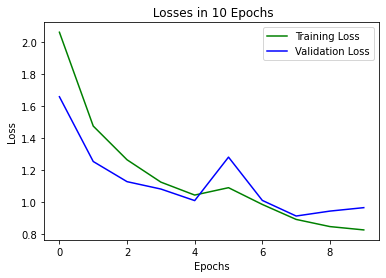

In [16]:
training_losses = model2_final_history.history["loss"]
vali_losses = model2_final_history.history["val_loss"]
epochs = range(0,10)
plt.plot(epochs,training_losses,"g",label = "Training Loss")
plt.plot(epochs,vali_losses,"b",label = "Validation Loss")
plt.title(" Losses in 10 Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

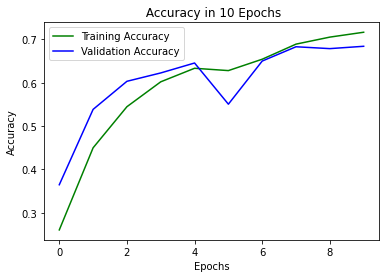

In [17]:
training_accuracy = model2_final_history.history["accuracy"]
vali_accuracy = model2_final_history.history["val_accuracy"]
epochs = range(0,10)
plt.plot(epochs,training_accuracy,"g",label = "Training Accuracy")
plt.plot(epochs,vali_accuracy,"b",label = "Validation Accuracy")
plt.title(" Accuracy in 10 Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

In [18]:
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    return np.argmax(final_model.predict(np.array([image,]), verbose=0))

# 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [19]:
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [27]:
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

OSError: ignored

The overall accuracy is  0.24 , which is better than random guess (which should have a accuracy around  0.10 ). For the project, you should try to improve the performance by the following strategies:

Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
Use both clean_noisy_trainset and noisy_trainset for model training via weakly supervised learning methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
Apply techniques such as  𝑘 -fold cross validation to avoid overfitting;
Any other reasonable strategies.

In [20]:
evaluation(model_II, clean_labels[:1000], imgs[:1000])

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       102
           1       0.88      0.92      0.90       112
           2       0.57      0.61      0.59        99
           3       0.52      0.15      0.24        92
           4       0.79      0.71      0.74        99
           5       0.47      0.87      0.61        85
           6       0.72      0.79      0.75       107
           7       0.83      0.84      0.84       102
           8       0.94      0.68      0.79        99
           9       0.84      0.92      0.88       103

    accuracy                           0.73      1000
   macro avg       0.73      0.72      0.71      1000
weighted avg       0.74      0.73      0.72      1000



In [29]:
evaluation(baseline_model, clean_labels[:1000], imgs[:1000])

              precision    recall  f1-score   support

           0       0.32      0.45      0.37       102
           1       0.18      0.25      0.21       112
           2       0.24      0.05      0.08        99
           3       0.23      0.15      0.18        92
           4       0.26      0.52      0.34        99
           5       0.18      0.12      0.14        85
           6       0.28      0.36      0.31       107
           7       0.55      0.06      0.11       102
           8       0.27      0.44      0.34        99
           9       0.23      0.12      0.15       103

    accuracy                           0.25      1000
   macro avg       0.27      0.25      0.22      1000
weighted avg       0.27      0.25      0.23      1000

